# Transfer Learning with TensorFlow: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.


## Downloading and becoming one with the data

In [1]:
# How many images in each folder?
import os

# Walk thorugh 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent\test.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\steak.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi.
There are 

## Creating data loaders (preparing the data)

We will use the `ImageDataGenerator` class to load in our images in batches.

In [2]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Trainig images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')
print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Trainig images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to yout models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [3]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

**Note:** You can customize the directory where your TensorBoard logs (model trainig metrics) get saved to whatever you like. The `log_dir` parameter we have created above is only one option.

## Creating models using TensorFlow Hub

In the past we have used TensorFlow to create our own models layer by layer from scratch.

Now we are going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://www.kaggle.com/models?tfhub-redirect=true

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1"

In [4]:
# Let's compare the following two models
resnet_url = 'https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/classification/1'

efficientnet_url = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1'

In [5]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub # type: ignore
from tensorflow.keras import layers # type: ignore

In [6]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the already learned patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,))
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ]) 

    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [14]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25612201  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,622,221
Trainable params: 10,020
Non-trainable params: 25,612,201
_________________________________________________________________


In [16]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [17]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                    epochs=10,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),
                                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                           experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20250710-170945
Epoch 1/10
24/24 [==============================] - 21s 397ms/step - loss: 2.2918 - accuracy: 0.1547 - val_loss: 2.2807 - val_accuracy: 0.2788
Epoch 2/10
24/24 [==============================] - 8s 341ms/step - loss: 2.2750 - accuracy: 0.3147 - val_loss: 2.2640 - val_accuracy: 0.4220
Epoch 3/10
24/24 [==============================] - 8s 340ms/step - loss: 2.2591 - accuracy: 0.4493 - val_loss: 2.2477 - val_accuracy: 0.5036
Epoch 4/10
24/24 [==============================] - 8s 336ms/step - loss: 2.2429 - accuracy: 0.5053 - val_loss: 2.2311 - val_accuracy: 0.5280
Epoch 5/10
24/24 [==============================] - 8s 337ms/step - loss: 2.2271 - accuracy: 0.5373 - val_loss: 2.2149 - val_accuracy: 0.5492
Epoch 6/10
24/24 [==============================] - 8s 340ms/step - loss: 2.2115 - accuracy: 0.5760 - val_loss: 2.1987 - val_accuracy: 0.5596
Epoch 7/10
24/24 [==============================] - 8s 339ms/step - loss

Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substatially) and in a quicker training time AND with only 10% of the training examples.

In [11]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow History object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

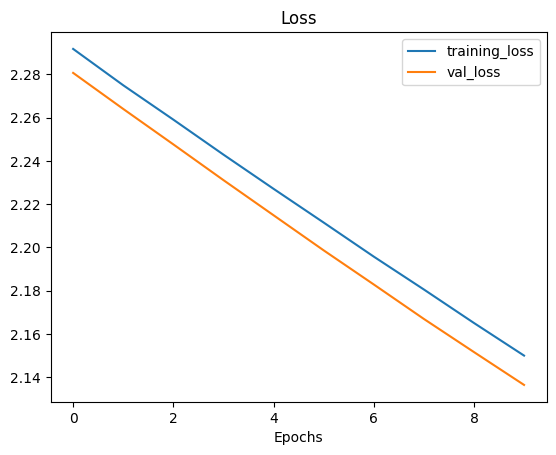

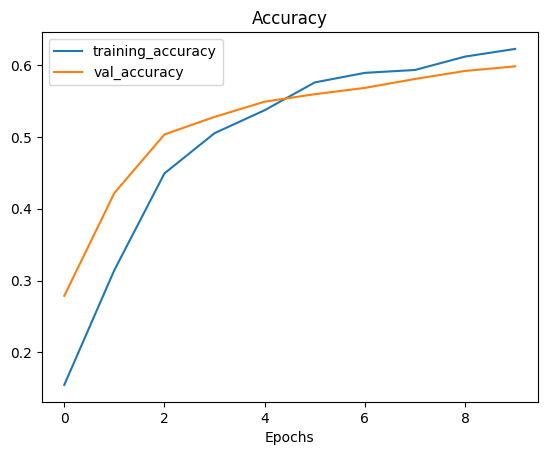

In [19]:
plot_loss_curves(history=resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [23]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=10,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20250710-172027
Epoch 1/10
24/24 [==============================] - 23s 500ms/step - loss: 2.2893 - accuracy: 0.2280 - val_loss: 2.2794 - val_accuracy: 0.3968
Epoch 2/10
24/24 [==============================] - 8s 355ms/step - loss: 2.2745 - accuracy: 0.3933 - val_loss: 2.2646 - val_accuracy: 0.4520
Epoch 3/10
24/24 [==============================] - 8s 334ms/step - loss: 2.2602 - accuracy: 0.4600 - val_loss: 2.2501 - val_accuracy: 0.5576
Epoch 4/10
24/24 [==============================] - 8s 337ms/step - loss: 2.2463 - accuracy: 0.5600 - val_loss: 2.2356 - val_accuracy: 0.5932
Epoch 5/10
24/24 [==============================] - 9s 366ms/step - loss: 2.2321 - accuracy: 0.5933 - val_loss: 2.2212 - val_accuracy: 0.6140
Epoch 6/10
24/24 [==============================] - 8s 359ms/step - loss: 2.2181 - accuracy: 0.6147 - val_loss: 2.2066 - val_accuracy: 0.6344
Epoch 7/10
24/24 [==============================] - 9s 378ms/step - 

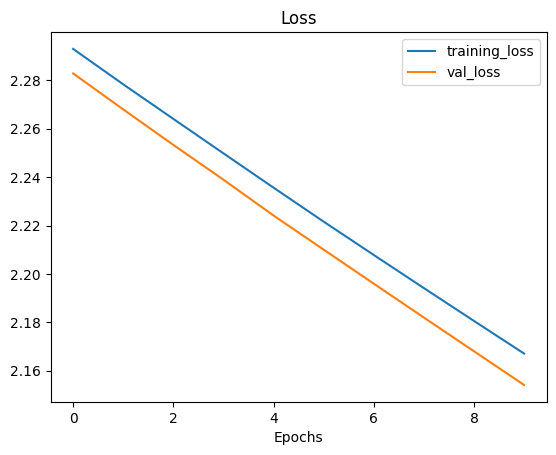

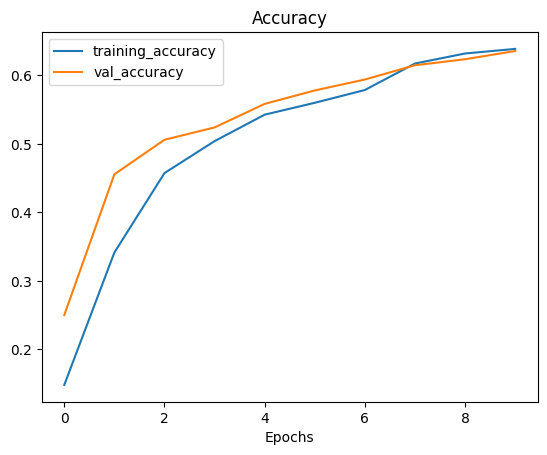

In [21]:
plot_loss_curves(history=efficientnet_history)

In [27]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

311

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 IMageNet classes, none of your own).
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food).
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (includinf new output layers).

## Comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

Write `tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature extraction model architectures using 10 percent of the data" --one_shot` on a shell to upload TensorBoard

Our TensorBoard experiments are uploaded publically.

* To check out what TensorBoard experiments you hav, just run `tensorboard dev list`.
* To delete an experiment `tensorboard dev delete --experiment_id XXXXXXXXXX`.

### Creating and testing MobileNetV2 TensorFlow Hub Feature Extraction model

In [7]:
mobilenet_url = 'https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/1'

In [ ]:
# Create the MobileNetV2 model
mobilenet_model = create_model(model_url=mobilenet_url,
                                num_classes=train_data_10_percent.num_classes)

In [12]:
# Compile MobileNetV2
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [14]:
# Fit the 10% data to the compiled MobileNetV2 model
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=10,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                              experiment_name="mobilenetv2")
                                        )

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20250711-170858
Epoch 1/10
24/24 [==============================] - 25s 485ms/step - loss: 1.9528 - accuracy: 0.3467 - val_loss: 1.2725 - val_accuracy: 0.6316
Epoch 2/10
24/24 [==============================] - 8s 359ms/step - loss: 1.0094 - accuracy: 0.7187 - val_loss: 0.9026 - val_accuracy: 0.7360
Epoch 3/10
24/24 [==============================] - 8s 354ms/step - loss: 0.7274 - accuracy: 0.8040 - val_loss: 0.7551 - val_accuracy: 0.7676
Epoch 4/10
24/24 [==============================] - 8s 355ms/step - loss: 0.5707 - accuracy: 0.8440 - val_loss: 0.6775 - val_accuracy: 0.7888
Epoch 5/10
24/24 [==============================] - 8s 349ms/step - loss: 0.4681 - accuracy: 0.9000 - val_loss: 0.6369 - val_accuracy: 0.7980
Epoch 6/10
24/24 [==============================] - 8s 352ms/step - loss: 0.3935 - accuracy: 0.9240 - val_loss: 0.6123 - val_accuracy: 0.8028
Epoch 7/10
24/24 [==============================] - 8s 349ms/step - los

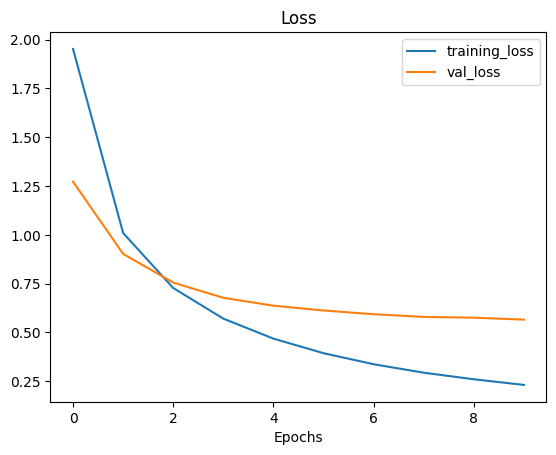

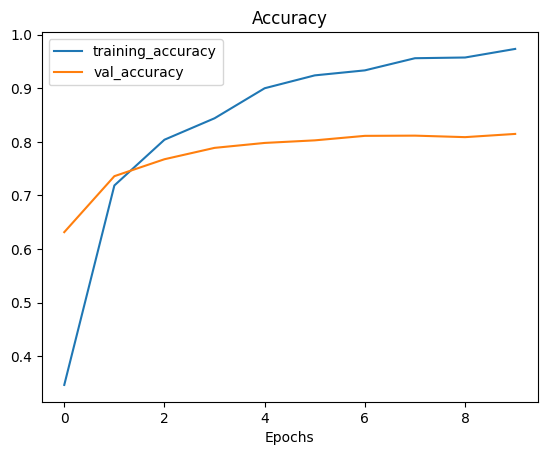

In [15]:
plot_loss_curves(history=mobilenet_history)